In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import jVMC
import jax 
import jax.numpy as jnp
import jax.random as jrnd
import matplotlib.pyplot as plt
import numpy as np
jax.devices()

2024-10-10 15:23:34.854795: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0)]

In [2]:
parameterRWKV = {
            "L": 8,
            "LHilDim": 5,
            "patch_size": 2,
            "hidden_size": 8,
            "num_heads": 2,
            "num_layers": 2,
            "embedding_size": 4
}
parameterGPT = {
            "L": 8,
            "LHilDim": 5,
            "patch_size": 2,
            "embeddingDim": 8,
            "depth" : 2,
            "nHeads" : 2,
            "hiddenDim": 8,
}
parameterGPT_not_pached = {
            "L": 8,
            "LocalHilDim": 5,
            "embeddingDim": 8,
            "depth" : 2,
            "nHeads" : 2,
            "hiddenDim": 8,
}
L = parameterRWKV["L"]
N = L
#net = jVMC.nets.CpxRWKV_patched(**parameterRWKV)
net = jVMC.nets.bosons.GPT_patched(**parameterGPT)
#net = jVMC.nets.bosons.GPT(**parameterGPT_not_pached)
print(net.__name__)
batSize = 2**10
psi = jVMC.vqs.NQS(net,batchSize=batSize)
key = jrnd.PRNGKey(11)
sampler = jVMC.sampler.MCSampler(psi,(parameterRWKV["L"],),key,numSamples=2**2)
sampler.sample()


GPT_patched


(Array([[[2, 0, 0, 4, 3, 2, 3, 4],
         [0, 2, 3, 4, 2, 3, 1, 1],
         [1, 1, 4, 3, 2, 1, 4, 1],
         [3, 4, 0, 2, 3, 2, 3, 0]]], dtype=int64),
 Array([[-5.41504599, -5.86281797, -5.96513374, -4.3121604 ]], dtype=float64),
 Array([[0.25, 0.25, 0.25, 0.25]], dtype=float64))

In [3]:
testFock = jnp.array([[[N]+[0]*(L-1), [1]*L]]) 

testFockWrong = jnp.array([[[2]+[1]*(L-1), [0]*L, [2]*L, [3]+[0]*(L-1)]]) 
psi(testFock)

Array([[        nan, -6.15892964]], dtype=float64)

In [4]:
par_net = jVMC.nets.particle_conservation_patched(net,N)

#par_net = jVMC.nets.particle_conservation(net,N)
psi_par = jVMC.vqs.NQS(par_net,batchSize=batSize)
sample_par = jVMC.sampler.MCSampler(psi_par,(parameterRWKV["L"],),key,numSamples=2**2)
sample_par.sample()

(Array([[[2, 0, 3, 2, 0, 0, 1, 0],
         [0, 2, 3, 2, 0, 0, 0, 1],
         [1, 2, 1, 0, 0, 4, 0, 0],
         [3, 1, 1, 1, 0, 2, 0, 0]]], dtype=int64),
 Array([[-3.38897165, -2.94597628, -5.13685617, -2.9364193 ]], dtype=float64),
 Array([[0.25, 0.25, 0.25, 0.25]], dtype=float64))

In [5]:
psi_par(testFock),psi_par(testFockWrong)  

(Array([[        nan, -4.74225621]], dtype=float64),
 Array([[-inf, -inf, -inf, -inf]], dtype=float64))

In [6]:
sym= jVMC.util.symmetries.get_orbit_1D(L,"reflection","translation")
sym_par_net = jVMC.nets.sym_wrapper.SymNet(sym,par_net,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)
psi_sym_par = jVMC.vqs.NQS(sym_par_net,batchSize=batSize)

print(psi_sym_par(testFock),psi_sym_par(testFockWrong))
sample_sym_par = jVMC.sampler.MCSampler(psi_sym_par,(parameterRWKV["L"],),key,numSamples=2**2)
sample_sym_par.sample()

[[        nan -3.70431508]] [[-inf -inf -inf -inf]]


(Array([[[2, 3, 0, 2, 0, 1, 0, 0],
         [0, 0, 2, 3, 2, 0, 0, 1],
         [0, 1, 0, 1, 2, 1, 2, 1],
         [0, 0, 1, 1, 1, 4, 0, 1]]], dtype=int64),
 Array([[-4.22182299, -4.06114397, -4.28015103, -4.34660996]], dtype=float64),
 Array([[0.25, 0.25, 0.25, 0.25]], dtype=float64))

[]

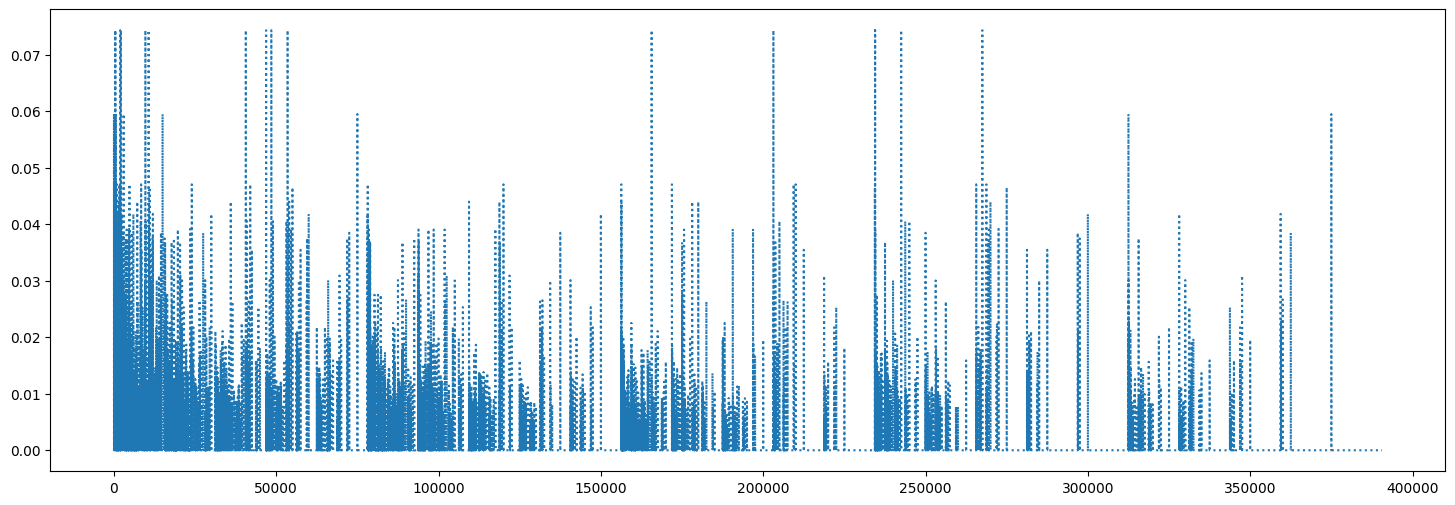

In [7]:
EpsiSampler = jVMC.sampler.ExactSampler(psi_sym_par, (L,),lDim=parameterRWKV["LHilDim"])
psi_s, psi_logPsi, psi_p = EpsiSampler.sample()
var_wf = jnp.abs(jnp.exp(psi_logPsi))[0]
var_wf /= var_wf.dot(var_wf)**0.5

figure = plt.figure(dpi=100, figsize=(18, 6))
#plt.plot(data_at_time)#np.e?xp(chi(psi_s))[0]/sum(np.exp(2.*chi(psi_s))[0])**0.5)
# plt.plot(data_at_time)
plt.plot(var_wf,':')
#plt.plot(data_at_time)
#plt.ylim(0,.7)
plt.plot()

(0.0, 1000000.0)

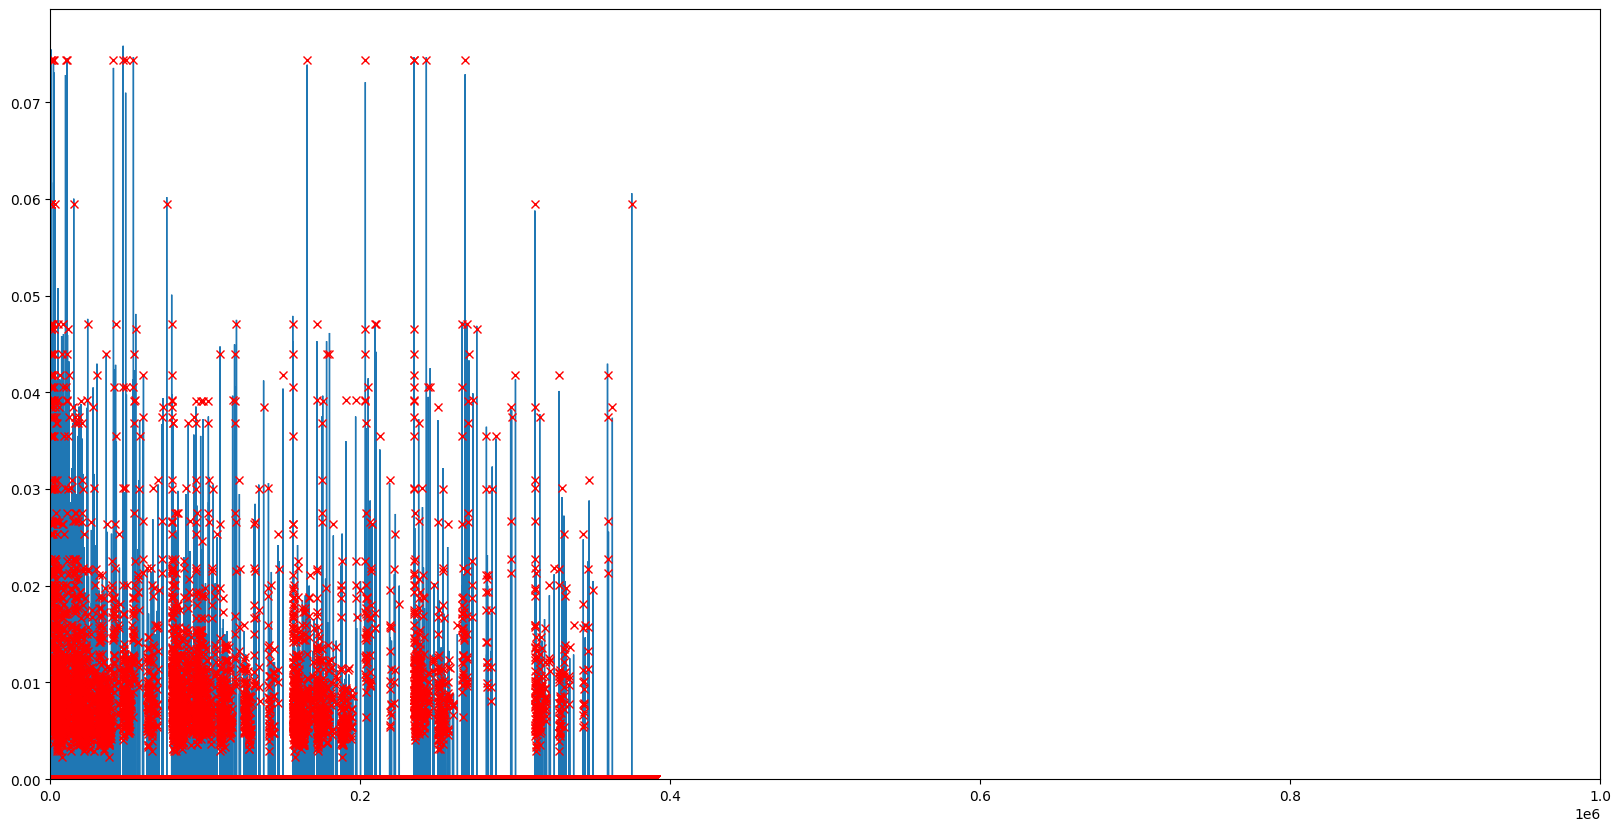

In [8]:
ldim = parameterRWKV["LHilDim"]
numSamples = 2**10
repeats = 100
sampled_s, psi_logPsi, psi_p = sample_sym_par.sample(numSamples=numSamples)
sampled_s,psi_logPsi
psi_histogram = (ldim**(L-jnp.arange(L)-1)*sampled_s[0]).sum(axis=-1)
weights = psi_p[0]
for i in range(repeats-1):
    sampled_s, psi_logPsi, psi_p = sample_sym_par.sample(numSamples=numSamples)
    sampled_s,psi_logPsi
    psi_histogram = jnp.concatenate((psi_histogram,(ldim**(L-jnp.arange(L)-1)*sampled_s[0]).sum(axis=-1)))
    weights = jnp.concatenate((weights,psi_p[0]))

fig = plt.figure(dpi=100, figsize=(20, 10))
const = 0#0.00001
counts, bins = np.histogram(psi_histogram,weights=weights,bins=ldim**L)
#counts, bins = np.histogram(psi_histogram,bins=ldim**L)

plt.stairs(jnp.sqrt(counts/sum(counts))+const, bins)
#plt.stairs(chi_counts/max(chi_counts), chi_bins)
plt.plot(var_wf+const,'x',c='r')
plt.xlim(0,1e6)
#plt.semilogy()

(0.0, 100000.0)

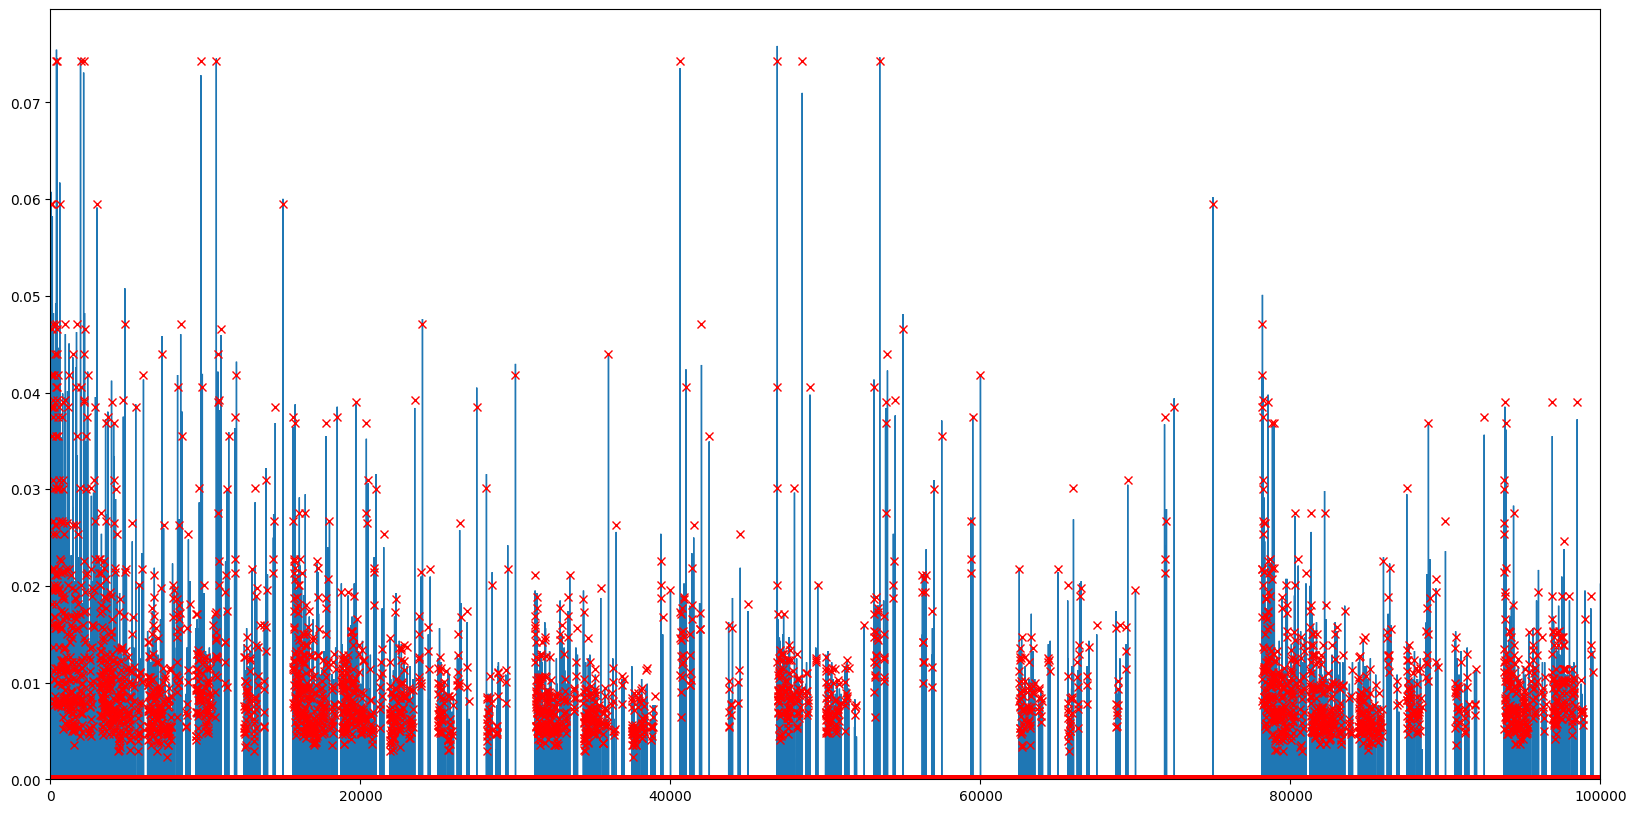

In [9]:
fig = plt.figure(dpi=100, figsize=(20, 10))

plt.stairs(jnp.sqrt(counts/sum(counts))+const, bins)
#plt.stairs(chi_counts/max(chi_counts), chi_bins)
plt.plot(var_wf+const,'x',c='r')
plt.xlim(0,1e5)

(0.0, 1000.0)

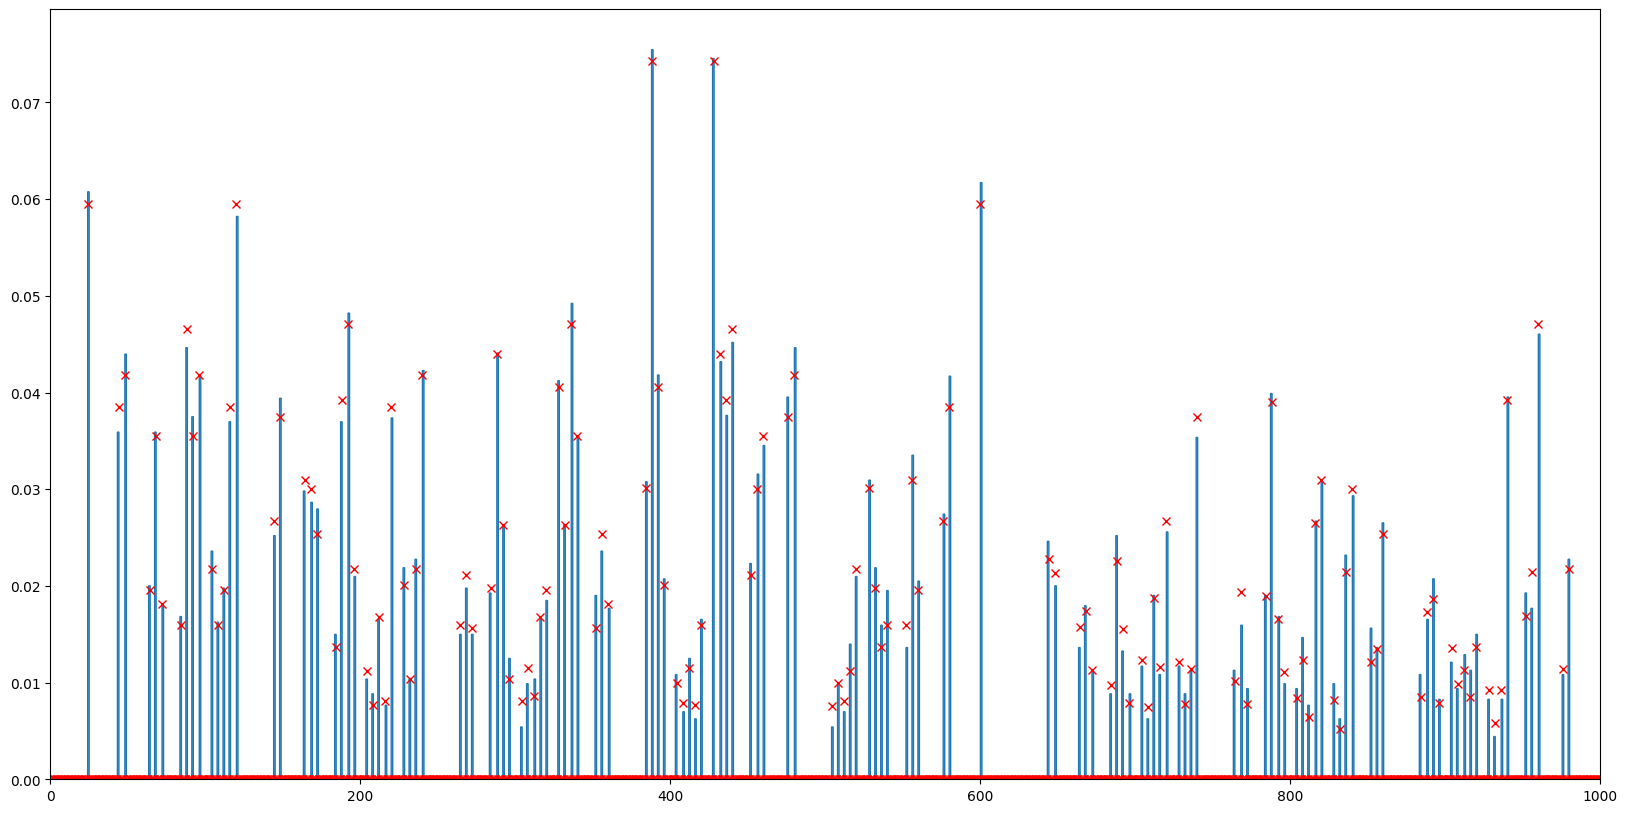

In [10]:
fig = plt.figure(dpi=100, figsize=(20, 10))

plt.stairs(jnp.sqrt(counts/sum(counts))+const, bins)
#plt.stairs(chi_counts/max(chi_counts), chi_bins)
plt.plot(var_wf+const,'x',c='r')
plt.xlim(0,1e3)